In [9]:
import pandas as pd
from sklearn import model_selection
from sklearn import tree, linear_model, svm, ensemble, metrics
from matplotlib import pyplot as plt
import xgboost as xgb

%matplotlib inline

In [10]:
DATA_FILE = "data_table_percentile.tsv"
df = pd.read_csv(DATA_FILE, sep="\t")
label = df["sensitivity_label"].copy()
data = df.drop("sensitivity_label", axis=1)
data.set_index(data.cell_drug_pair, inplace=True)
data.drop("cell_drug_pair", axis=1, inplace=True)
data.drop("cell", axis=1, inplace=True)
data.drop("drug", axis=1, inplace=True)

In [33]:
Classifiers = {"Random Forest": ensemble.RandomForestRegressor(),
               "SVM": svm.SVR(kernel="rbf"), 
               "XGBoost": xgb.XGBRegressor(n_estimators=200)}

In [34]:
kf = model_selection.KFold(n_splits=5)
result_df = pd.DataFrame()
fold_num = 0
for train, test in kf.split(df):
    fold_num += 1
    tr, val = model_selection.train_test_split(train, test_size=0.2, random_state=0)
    
    x_train = data.iloc[tr]
    y_train = label.iloc[tr].as_matrix()
    x_val = data.iloc[val]
    y_val = label.iloc[val].as_matrix()
    x_test = data.iloc[test]
    y_test = label.iloc[test].as_matrix()
        
    for classfier_name, clf in Classifiers.iteritems():
        clf.fit(x_train, y_train)
        prediction = clf.predict(x_val)
        mse = metrics.mean_squared_error(prediction, y_val)
        result_df.loc[fold_num, classfier_name] = mse
        
print result_df


    XGBoost       SVM  Random Forest
1  0.027341  0.031554       0.027019
2  0.023985  0.029186       0.027901
3  0.023904  0.027453       0.025097
4  0.023427  0.027944       0.027424
5  0.021677  0.025362       0.026180


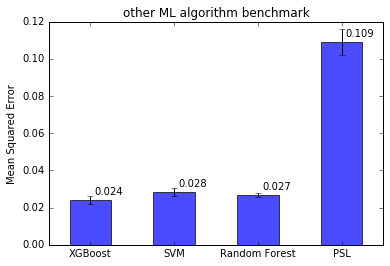

In [52]:
psl_mean = 0.109
psl_std = 0.007
means = result_df.mean()
means["PSL"] = psl_mean
stds = result_df.std()
stds["PSL"] = psl_std
            
ax = means.plot.bar(yerr=stds, alpha=0.7, rot=0)
ax.set_ylabel("Mean Squared Error")
for rect in ax.patches:
    height = rect.get_height()
    height_label = "%.3f" % height
    ax.text(rect.get_x() + rect.get_width()/2 + 0.05, height + 0.003, height_label)
ax.set_title("other ML algorithm benchmark")
plt.savefig("../plots/benchmark.png", ppi=200)